# Imports Required

In [1]:

pip install Boruta

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from IPython.core.display  import HTML
# import holidays
from datetime              import date
import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sb.set()

jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 1) IMPORTING and LOADING DATA:

In [4]:
aep = pd.read_csv( 'AEP_hourly.csv')
comed = pd.read_csv( 'COMED_hourly.csv')
dayton = pd.read_csv( 'DAYTON_hourly.csv')
deok = pd.read_csv('DEOK_hourly.csv')
dom = pd.read_csv( 'DOM_hourly.csv')
duq = pd.read_csv( 'DUQ_hourly.csv')
ekpc = pd.read_csv( 'EKPC_hourly.csv')
fe = pd.read_csv( 'FE_hourly.csv')
ni = pd.read_csv( 'NI_hourly.csv')
pjm = pd.read_csv( 'PJM_Load_hourly.csv')
pjme = pd.read_csv( 'PJME_hourly.csv')
pjmw = pd.read_csv( 'PJMW_hourly.csv')

In [5]:
# COMBINE ALL DATASETS INTO ONE. 
# CREATING A COLUMN WHICH CAN IDENTIFY THE RESPECTIVE ELECTRIC COMPANIES

aep['electric_company'] = 'AEP'
comed['electric_company'] = 'COMED'
dayton['electric_company'] = 'DAYTON'
deok['electric_company'] = 'DEOK'
dom['electric_company'] = 'DOM'
duq['electric_company'] = 'DUQ'
ekpc['electric_company'] = 'EKPC'
fe['electric_company'] = 'FE'
ni['electric_company'] = 'NI'
pjm['electric_company'] = 'PJM'
pjme['electric_company'] = 'PJME'
pjmw['electric_company'] = 'PJMW'

In [6]:
# EACH REGION HAS DIFFERENT COLUMN NAME FOR ENERGY CONSUMPTION, SO CHANGE THEM INTO A COMMON NAME:

aep = aep.rename( columns={'AEP_MW': 'mw_energy_consumption'} )
comed = comed.rename( columns={'COMED_MW': 'mw_energy_consumption'} )
dayton = dayton.rename( columns={'DAYTON_MW': 'mw_energy_consumption'} )
deok = deok.rename( columns={'DEOK_MW': 'mw_energy_consumption'} )
dom = dom.rename( columns={'DOM_MW': 'mw_energy_consumption'} )
duq = duq.rename( columns={'DUQ_MW': 'mw_energy_consumption'} )
ekpc = ekpc.rename( columns={'EKPC_MW': 'mw_energy_consumption'} )
fe = fe.rename( columns={'FE_MW': 'mw_energy_consumption'} )
ni = ni.rename( columns={'NI_MW': 'mw_energy_consumption'} )
pjm = pjm.rename( columns={'PJM_Load_MW': 'mw_energy_consumption'} )
pjme = pjme.rename( columns={'PJME_MW': 'mw_energy_consumption'} )
pjmw = pjmw.rename( columns={'PJMW_MW': 'mw_energy_consumption'} )

In [7]:
# SHAPE OF THE DATASET OF EACH OF THE ELECTRIC COMPANY :

print("Shape of AEP electric company : ",aep.shape)
print("Shape of COMED electric company : ",comed.shape)
print("Shape of DAYTON electric company : ",dayton.shape)
print("Shape of DEOK electric company : ",deok.shape)
print("Shape of DOM electric company : ",dom.shape)
print("Shape of DUQ electric company : ",duq.shape)
print("Shape of EKPC electric company : ",ekpc.shape)
print("Shape of FE electric company : ",fe.shape)
print("Shape of NI electric company : ",ni.shape)
print("Shape of PJM electric company : ",pjm.shape)
print("Shape of PJME electric company : ",pjme.shape)
print("Shape of PJMW electric company : ",pjmw.shape)

Shape of AEP electric company :  (121273, 3)
Shape of COMED electric company :  (66497, 3)
Shape of DAYTON electric company :  (121275, 3)
Shape of DEOK electric company :  (57739, 3)
Shape of DOM electric company :  (116189, 3)
Shape of DUQ electric company :  (119068, 3)
Shape of EKPC electric company :  (45334, 3)
Shape of FE electric company :  (62874, 3)
Shape of NI electric company :  (58450, 3)
Shape of PJM electric company :  (32896, 3)
Shape of PJME electric company :  (145366, 3)
Shape of PJMW electric company :  (143206, 3)


### Concatenating all the 12 datasets that we previously loaded into one dataset

In [8]:
df = pd.concat([aep,comed,dayton,deok,dom,duq,ekpc,fe,ni,pjm,pjme,pjmw])
df.sample(10)

,Datetime,mw_energy_consumption,electric_company
8581,2005-01-08 16:00:00,1713.0,DUQ
36282,2015-06-13 23:00:00,7835.0,FE
42337,2009-03-03 12:00:00,1928.0,DUQ
13947,2003-02-28 08:00:00,6837.0,PJMW
4849,2005-09-12 04:00:00,1646.0,DAYTON
54525,2010-01-11 12:00:00,2635.0,DAYTON
24077,2000-01-03 12:00:00,30253.0,PJM
112601,2018-05-30 12:00:00,12775.0,DOM
90196,2015-12-16 03:00:00,12882.0,AEP
31595,2017-12-25 13:00:00,1870.0,EKPC


In [9]:
# SHAPE OF THE DATASET

df.shape

(1090167, 3)

# 2. DATA DESCRIPTION :

## Renaming Coulmns

In [10]:
# we are creating copies at the start so that it's easier to load data if we face a problem in future
df1 = df.copy()

In [11]:
# let's see what we have here
df1.columns

Index(['Datetime', 'mw_energy_consumption', 'electric_company'], dtype='object')

In [12]:
# we are renaming so that get the format of the column 'datetime' that we want
column_new = ['datetime', 'mw_energy_consumption','electric_company']

# RENAME :
df1.columns = column_new
df1.columns

Index(['datetime', 'mw_energy_consumption', 'electric_company'], dtype='object')

## Data dimensions

In [13]:
# DATA DIMENSIONS:

print("Number of rows : ",df1.shape[0])
print("Number of columns : ",df1.shape[1])

Number of rows :  1090167
Number of columns :  3


## Data types

In [14]:
# DATATYPES : 
print("Before updating : ")
print(df1.dtypes)

# datetime column has object datatype. Let's change it into datetime format for processing the data.

df1['datetime'] = pd.to_datetime(df1['datetime'])

# DATATYPES : 
print("\nAfter updating : ")
print(df1.dtypes)

Before updating : 
datetime                  object
mw_energy_consumption    float64
electric_company          object
dtype: object

After updating : 
datetime                 datetime64[ns]
mw_energy_consumption           float64
electric_company                 object
dtype: object


## Check NA values

In [15]:
# CHECK FOR NULL VALUES : 

df1.isnull().sum()

datetime                 0
mw_energy_consumption    0
electric_company         0
dtype: int64

# Let's Analyse & Visualize our dataset

In [16]:
df1.head()#checking the head i.e. top 5 values of the dataset

,datetime,mw_energy_consumption,electric_company
0,2004-12-31 01:00:00,13478.0,AEP
1,2004-12-31 02:00:00,12865.0,AEP
2,2004-12-31 03:00:00,12577.0,AEP
3,2004-12-31 04:00:00,12517.0,AEP
4,2004-12-31 05:00:00,12670.0,AEP


In [17]:
df1.info() #checking the information

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1090167 entries, 0 to 143205
Data columns (total 3 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   datetime               1090167 non-null  datetime64[ns]
 1   mw_energy_consumption  1090167 non-null  float64       
 2   electric_company       1090167 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 33.3+ MB


In [18]:
df1.describe(include = 'all')

<ipython-input-18-eb74bb2a2b38>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df1.describe(include = 'all')


,datetime,mw_energy_consumption,electric_company
count,1090167,1.090167e+06,1090167
unique,178258,NaN,12
top,2016-11-06 02:00:00,NaN,PJME
freq,20,NaN,145366
first,1998-04-01 01:00:00,NaN,NaN
last,2018-08-03 00:00:00,NaN,NaN
mean,NaN,1.120959e+04,NaN
std,NaN,1.053440e+04,NaN
min,NaN,0.000000e+00,NaN
25%,NaN,2.455000e+03,NaN


In [19]:
df1['mw_energy_consumption'].describe()

count    1.090167e+06
mean     1.120959e+04
std      1.053440e+04
min      0.000000e+00
25%      2.455000e+03
50%      8.217000e+03
75%      1.466500e+04
max      6.200900e+04
Name: mw_energy_consumption, dtype: float64

In [20]:
print(df1['electric_company'].nunique())
print(df1['electric_company'].unique())

12
['AEP' 'COMED' 'DAYTON' 'DEOK' 'DOM' 'DUQ' 'EKPC' 'FE' 'NI' 'PJM' 'PJME'
 'PJMW']


### Plots

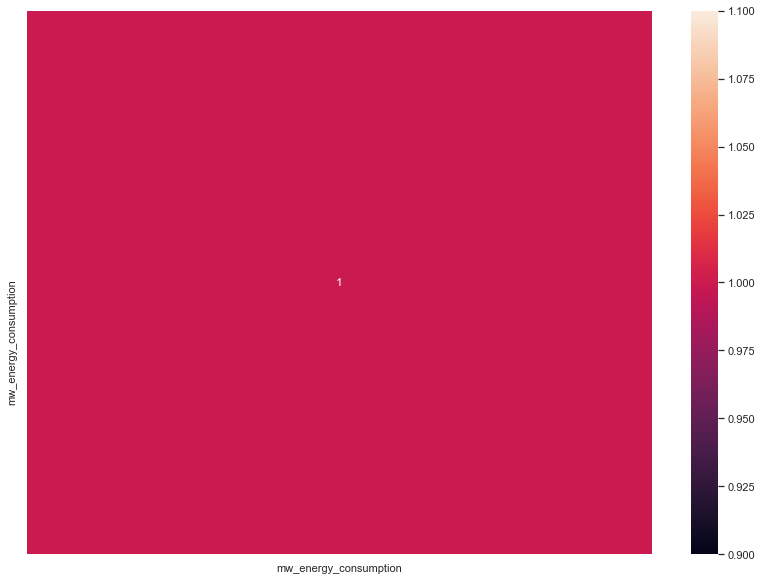

In [21]:
#let's see the correlation by referring the heatmap
plt.figure(figsize=(14,10))
sb.heatmap(df1.corr(), annot=True)
plt.show()
#Since we didn't divide our datetime column, therefore we currently have only one attribute 'mw_energy_consumption' to compare for our heatmap
# We'll see further when we analyse and break our 'datetime' ,how it effects our heatmap and vary amongst each other

PJME      145366
PJMW      143206
DAYTON    121275
AEP       121273
DUQ       119068
DOM       116189
COMED      66497
FE         62874
NI         58450
DEOK       57739
EKPC       45334
PJM        32896
Name: electric_company, dtype: int64

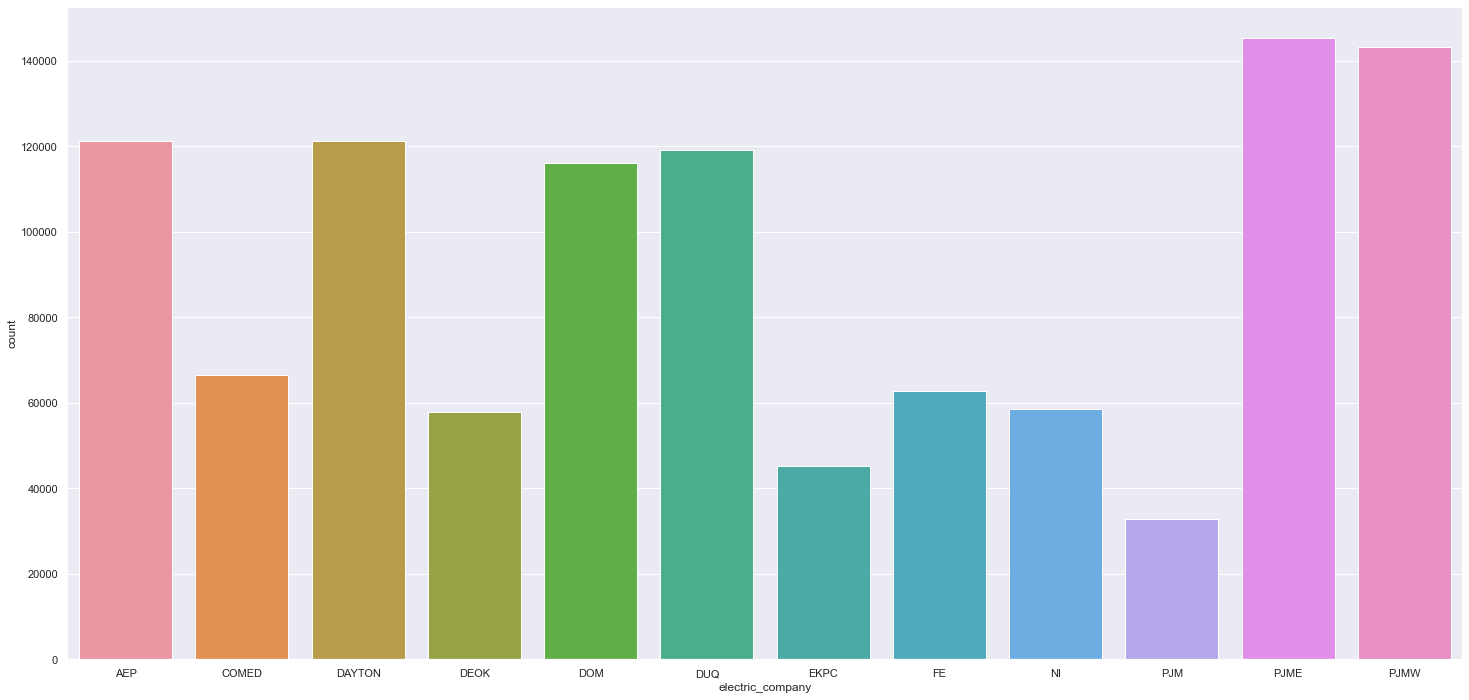

In [22]:
#Let's check the number of classes
sb.countplot(x="electric_company", data=df1)
df.loc[:,'electric_company'].value_counts()

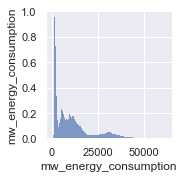

In [23]:
sb.pairplot(df1)
# As we saw in the heatmap that there's only one significant attribute or column now
# Along with the heatmap we'll also see what changes the pairplot brings

## Some statistical analysis

In [24]:
# divide into numerical and categorical columns, as they will be treated with different techniques.
num_attributes = df1.select_dtypes( include=['float64'] )
cat_attributes = df1.select_dtypes( exclude=['float64', 'datetime64[ns]'] )

In [25]:
num_attributes.sample() # checking the num_attributes

,mw_energy_consumption
44607,10081.0


In [26]:
cat_attributes.sample() # checking the cat_attributes

,electric_company
39934,PJME


### For numerical attributes

In [27]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ( ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,mw_energy_consumption,0.0,62009.0,62009.0,11209.58865,8217.0,10534.394704,1.356423,1.198281


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mw_energy_consumption', ylabel='Density'>

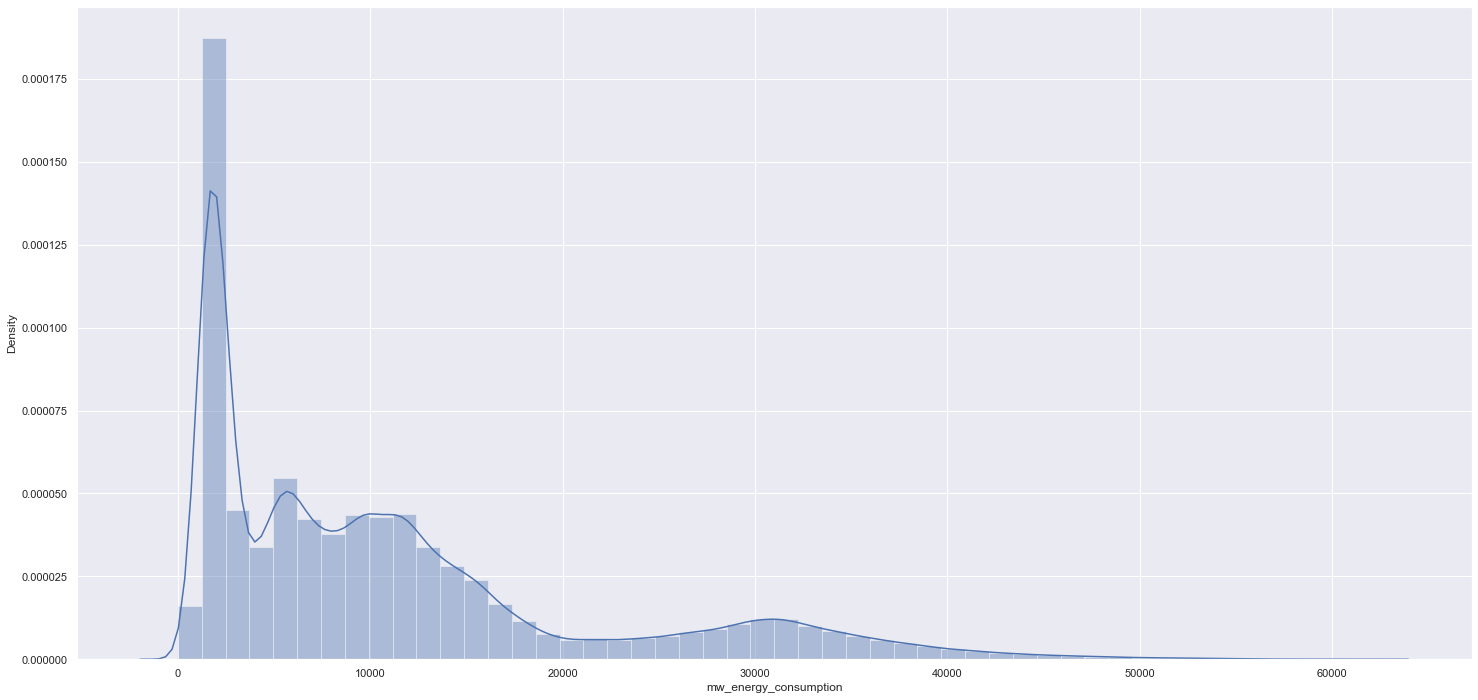

In [28]:
sb.distplot(df1['mw_energy_consumption'])

### For caterogical attributes

In [29]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

electric_company    12
dtype: int64

<AxesSubplot:xlabel='electric_company', ylabel='mw_energy_consumption'>

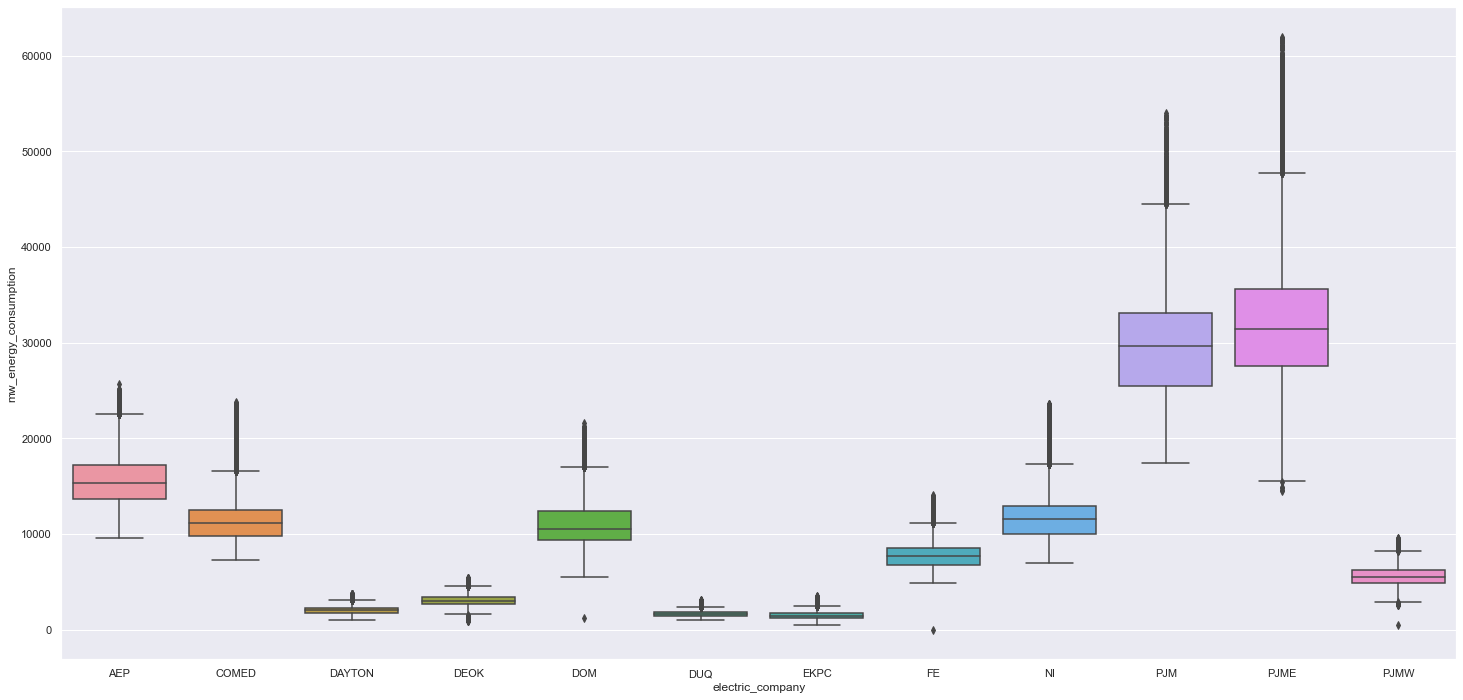

In [30]:
# BOX PLOT OF ENERGY CONSUMPTIONS OF ELECTRIC COMPANIES : 

sb.boxplot(x = 'electric_company', y = 'mw_energy_consumption', data = df1)

# 3. Feature Engineering


### Here we'll dig deep and modify one attribute (datetime) to give multiple attributes that will help us with the work for the further project and results


### Here we'll try to extract as much info as possible from the datetime attribute in order to get a better perspective and some more features that will make our custom dataset more biased (date, year, month, season, weekday etc.)


## We'll create some hypotheses of our own and then try to prove whether they are true or false with our model with various representations

# 3.1 HYPOTHESIS

There are several factors influencing the consumption of electricity. We now list out some hypothesis based on the factors that influence the consumption of electricity.

## 3.1.1 Hypothesis - Creation

#### **Demographic Hypothesis**

**1.** Consumption of Energy is observed to be less among the Elderly people

**2.** Larger families tend to expend more energy

**3.** The energy expenditure during the early mornings and late afternoons depends on the avtivity being carried out.

#### **Geographic Hypothesis**

**1.** Energy consumption level increases manifolds during hot Climates

**2.** Seasons of scorching heat witnesses an increase in the consumption of energy

**3.** People living in the Geograpical Locations located on the Tropics tend to consume greater energy 

**4.** Obervation of increased energy consumption during the colder seasons were made 

#### **Socio-cultural Hypothesis**

**1.** Increased energy consumption is seen from the regions receiving more sunlight. 

**2.** People tend to consume more energy during the weekends

**3.** Tribes expend very less energy

**4.** All Developed and Large Developing Nations tend to utilize a lot of energy

**5.** Defense, Research Institutes and Healthcare Institutes consume huge amounts of energy for their working

**6.** People staying indoors during the holidiays spend more energy

#### **Technical Hypothesis**

**1.** The Excessive use of technology can lead to utilization of huge amounts of energy

**2.** In Industries involving large amounts of machineries tend to consume huge amounts of energy

**3.** Running devices in factories can be observed to consume huge energies  

Since the amount of information provided to us through the dataset is limited, hence we restrict ourselves to te following final list of hypothesis.

## 3.1.2 Hypothesis - Final List 

**1.** Family activity influences energy expenditure in the early morning and late afternoon only

**2.** Seasons with higher or lower temperatures use more energy

**3.** Holiday periods spend more energy

**4.** Weekends periods spend more energy

## 3.2 Feature Engineering

In [31]:
# We are again making a copy for the same reason
df2 = df1.copy()

## DATE
# We want to have a view of the evolution of energy consumption by looking only at the dates as information, excluding an hour when they were recorded.

df2['date'] = df2['datetime'].dt.date

# FROM OBJECT DATATYPE TO DATE FORMAT
df2['date'] = pd.to_datetime(df2['date'])

## YEAR
# We will not directly validate any hypothesis with the date "year", but we will use this information to better visualize some variables in the validation process within the EDA.

df2['year'] = df2['datetime'].dt.year

## MONTH
# We will not directly validate any hypothesis with the date "month", but we will use this information to better visualize some variables in the validation process within the EDA.

df2['month'] = df2['datetime'].dt.month

## HOUR OF DAY
# Initially we thought about converting the hours in the "datetime" column to float, because it would be better to visualize the energy consumption by the evolution of the hours, but observing the part of the hours in the "datetime" column we can see that all of them have only the same hour and not the minute and second. For this reason we will only create the "hour_of_day" column using the "hour" function.

df2['hour_of_day'] = df2['datetime'].dt.hour

#SEASON
# season:

# - Winter -> December (12), January (01) and February (02);
# - Spring -> March (03), April (04) and May (05);
# - Summer -> Jun (06), July (07) and August (08);
# - Autumn -> September (09), October (10) and November (11).

df2['season'] = df2['datetime'].apply( lambda x: 'Winter' if x.month == 12 or x.month == 1 or x.month == 2 else 'Spring' if  x.month == 3 or x.month == 4 or x.month == 5 else 'Summer' if  x.month == 6 or x.month == 7 or x.month == 8 else 'Autumn' if  x.month == 9 or x.month == 10 or x.month == 11 else '')

#DAY OF WEEK
## day_of_week:

# 0 - Monday
# 1 - Tuesday
# 2 - Wednesday
# 3 - Thursday
# 4 - Friday
# 5 - Saturday
# 6 - Sunday

df2['day_of_week'] = df2['datetime'].dt.weekday

#HOLIDAYS
#df2['holidays'] = df2['datetime'].apply(lambda x: 'Holiday' if x in holidays.US() else 'Holiday' if x+datetime.timedelta(days=1) in holidays.US() else 'Normal day' )

df2.head()

,datetime,mw_energy_consumption,electric_company,date,year,month,hour_of_day,season,day_of_week
0,2004-12-31 01:00:00,13478.0,AEP,2004-12-31,2004,12,1,Winter,4
1,2004-12-31 02:00:00,12865.0,AEP,2004-12-31,2004,12,2,Winter,4
2,2004-12-31 03:00:00,12577.0,AEP,2004-12-31,2004,12,3,Winter,4
3,2004-12-31 04:00:00,12517.0,AEP,2004-12-31,2004,12,4,Winter,4
4,2004-12-31 05:00:00,12670.0,AEP,2004-12-31,2004,12,5,Winter,4


In [32]:
df2.dtypes

datetime                 datetime64[ns]
mw_energy_consumption           float64
electric_company                 object
date                     datetime64[ns]
year                              int64
month                             int64
hour_of_day                       int64
season                           object
day_of_week                       int64
dtype: object

In [33]:
cal = calendar()
holidays = cal.holidays(start=df2['datetime'].min(), end=df2['datetime'].max())
df2['holiday'] = df2['datetime'].dt.date.astype('datetime64').isin(holidays)

In [34]:
df2.head(100)

,datetime,mw_energy_consumption,electric_company,date,year,month,hour_of_day,season,day_of_week,holiday
0,2004-12-31 01:00:00,13478.0,AEP,2004-12-31,2004,12,1,Winter,4,True
1,2004-12-31 02:00:00,12865.0,AEP,2004-12-31,2004,12,2,Winter,4,True
2,2004-12-31 03:00:00,12577.0,AEP,2004-12-31,2004,12,3,Winter,4,True
3,2004-12-31 04:00:00,12517.0,AEP,2004-12-31,2004,12,4,Winter,4,True
4,2004-12-31 05:00:00,12670.0,AEP,2004-12-31,2004,12,5,Winter,4,True
5,2004-12-31 06:00:00,13038.0,AEP,2004-12-31,2004,12,6,Winter,4,True
6,2004-12-31 07:00:00,13692.0,AEP,2004-12-31,2004,12,7,Winter,4,True
7,2004-12-31 08:00:00,14297.0,AEP,2004-12-31,2004,12,8,Winter,4,True
8,2004-12-31 09:00:00,14719.0,AEP,2004-12-31,2004,12,9,Winter,4,True
9,2004-12-31 10:00:00,14941.0,AEP,2004-12-31,2004,12,10,Winter,4,True


In [35]:
df2.dtypes

datetime                 datetime64[ns]
mw_energy_consumption           float64
electric_company                 object
date                     datetime64[ns]
year                              int64
month                             int64
hour_of_day                       int64
season                           object
day_of_week                       int64
holiday                            bool
dtype: object

## Now let's analyse the new created dataset like we did for before

In [36]:
df2.head()

,datetime,mw_energy_consumption,electric_company,date,year,month,hour_of_day,season,day_of_week,holiday
0,2004-12-31 01:00:00,13478.0,AEP,2004-12-31,2004,12,1,Winter,4,True
1,2004-12-31 02:00:00,12865.0,AEP,2004-12-31,2004,12,2,Winter,4,True
2,2004-12-31 03:00:00,12577.0,AEP,2004-12-31,2004,12,3,Winter,4,True
3,2004-12-31 04:00:00,12517.0,AEP,2004-12-31,2004,12,4,Winter,4,True
4,2004-12-31 05:00:00,12670.0,AEP,2004-12-31,2004,12,5,Winter,4,True


In [37]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1090167 entries, 0 to 143205
Data columns (total 10 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   datetime               1090167 non-null  datetime64[ns]
 1   mw_energy_consumption  1090167 non-null  float64       
 2   electric_company       1090167 non-null  object        
 3   date                   1090167 non-null  datetime64[ns]
 4   year                   1090167 non-null  int64         
 5   month                  1090167 non-null  int64         
 6   hour_of_day            1090167 non-null  int64         
 7   season                 1090167 non-null  object        
 8   day_of_week            1090167 non-null  int64         
 9   holiday                1090167 non-null  bool          
dtypes: bool(1), datetime64[ns](2), float64(1), int64(4), object(2)
memory usage: 124.2+ MB


In [38]:
df2.describe(include="all")

<ipython-input-38-ac60ca0c82f2>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df2.describe(include="all")
<ipython-input-38-ac60ca0c82f2>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df2.describe(include="all")


,datetime,mw_energy_consumption,electric_company,date,year,month,hour_of_day,season,day_of_week,holiday
count,1090167,1.090167e+06,1090167,1090167,1.090167e+06,1.090167e+06,1.090167e+06,1090167,1.090167e+06,1090167
unique,178258,NaN,12,7430,NaN,NaN,NaN,4,NaN,2
top,2016-11-06 02:00:00,NaN,PJME,2014-11-02 00:00:00,NaN,NaN,NaN,Summer,NaN,False
freq,20,NaN,145366,250,NaN,NaN,NaN,280088,NaN,1060479
first,1998-04-01 01:00:00,NaN,NaN,1998-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,2018-08-03 00:00:00,NaN,NaN,2018-08-03 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.120959e+04,NaN,NaN,2.011060e+03,6.487686e+00,1.150143e+01,NaN,2.999160e+00,NaN
std,NaN,1.053440e+04,NaN,NaN,4.690830e+00,3.430180e+00,6.921832e+00,NaN,1.999801e+00,NaN
min,NaN,0.000000e+00,NaN,NaN,1.998000e+03,1.000000e+00,0.000000e+00,NaN,0.000000e+00,NaN
25%,NaN,2.455000e+03,NaN,NaN,2.007000e+03,4.000000e+00,6.000000e+00,NaN,1.000000e+00,NaN


In [39]:
df2.columns.nunique()

10

## Univariate Analysis

In [40]:
df3 = df2.copy()

In [41]:
df4 = df3.copy()

In [42]:
num_attributes = df2.select_dtypes(include = ["int64","float64"])
cat_attributes = df2.select_dtypes(exclude = ["int64","float64","datetime64[ns]"])
print("Numeric attributes : ",'\033[1m', num_attributes.columns,'\033[0m')
print()
print("Categorical attributes : ", '\033[1m', cat_attributes.columns,'\033[0m')

Numeric attributes :   Index(['mw_energy_consumption', 'year', 'month', 'hour_of_day', 'day_of_week'], dtype='object') 

Categorical attributes :   Index(['electric_company', 'season', 'holiday'], dtype='object') 


In [43]:
df2.sample(10).T

,61044,135519,40985,26357,48895,40248,99612,72063,67263,46182
datetime,2011-01-12 04:00:00,2017-04-17 16:00:00,2006-04-28 03:00:00,2014-12-29 12:00:00,2016-06-03 13:00:00,2009-08-29 11:00:00,2013-08-20 13:00:00,2010-07-13 10:00:00,2012-07-29 09:00:00,2010-09-24 19:00:00
mw_energy_consumption,1599,5001,21973,12126,13484,14828,41108,6093,1613,2244
electric_company,DUQ,PJMW,PJME,COMED,COMED,AEP,PJME,PJMW,DAYTON,DUQ
date,2011-01-12 00:00:00,2017-04-17 00:00:00,2006-04-28 00:00:00,2014-12-29 00:00:00,2016-06-03 00:00:00,2009-08-29 00:00:00,2013-08-20 00:00:00,2010-07-13 00:00:00,2012-07-29 00:00:00,2010-09-24 00:00:00
year,2011,2017,2006,2014,2016,2009,2013,2010,2012,2010
month,1,4,4,12,6,8,8,7,7,9
hour_of_day,4,16,3,12,13,11,13,10,9,19
season,Winter,Spring,Spring,Winter,Summer,Summer,Summer,Summer,Summer,Autumn
day_of_week,2,0,4,0,4,5,1,1,6,4
holiday,False,False,False,False,False,False,False,False,False,False


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mw_energy_consumption'>

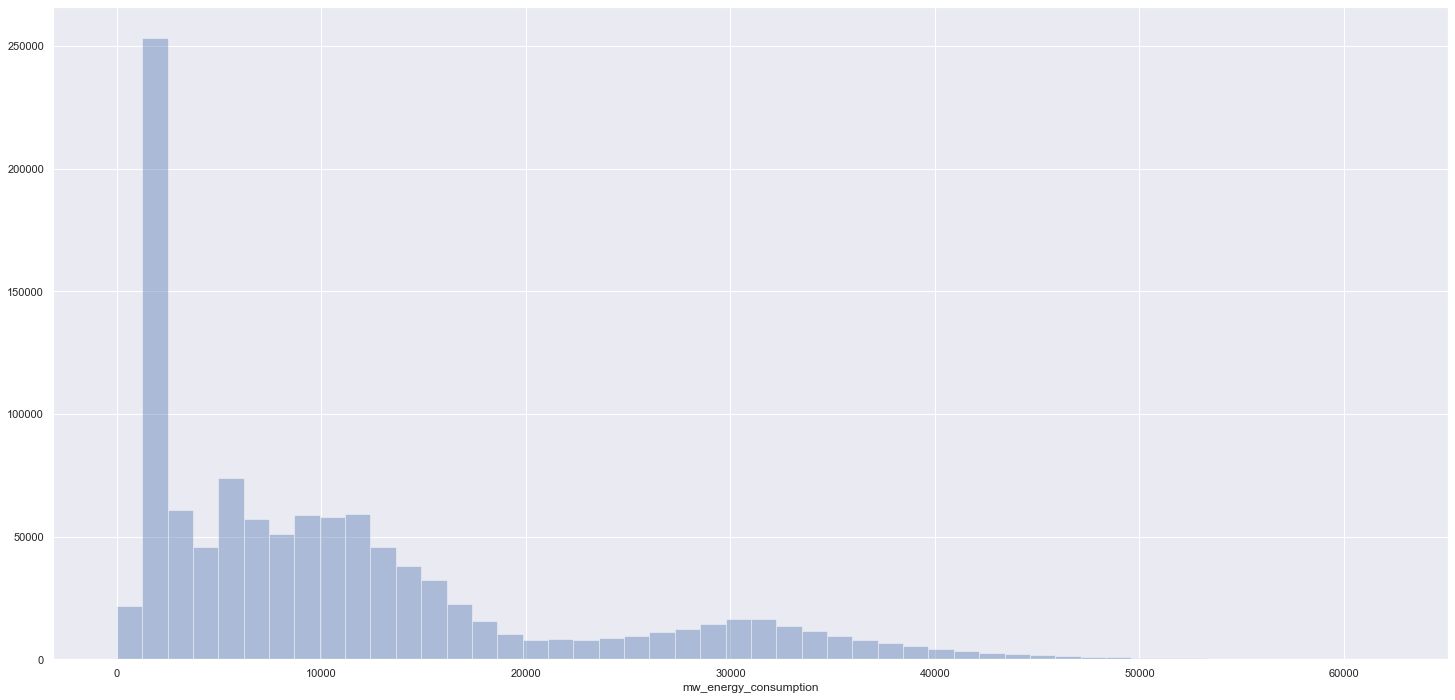

In [44]:
sb.distplot( df2['mw_energy_consumption'], kde=False )

## Numerical Variable

array([[<AxesSubplot:title={'center':'mw_energy_consumption'}>,
        <AxesSubplot:title={'center':'year'}>],
       [<AxesSubplot:title={'center':'month'}>,
        <AxesSubplot:title={'center':'hour_of_day'}>],
       [<AxesSubplot:title={'center':'day_of_week'}>, <AxesSubplot:>]],
      dtype=object)

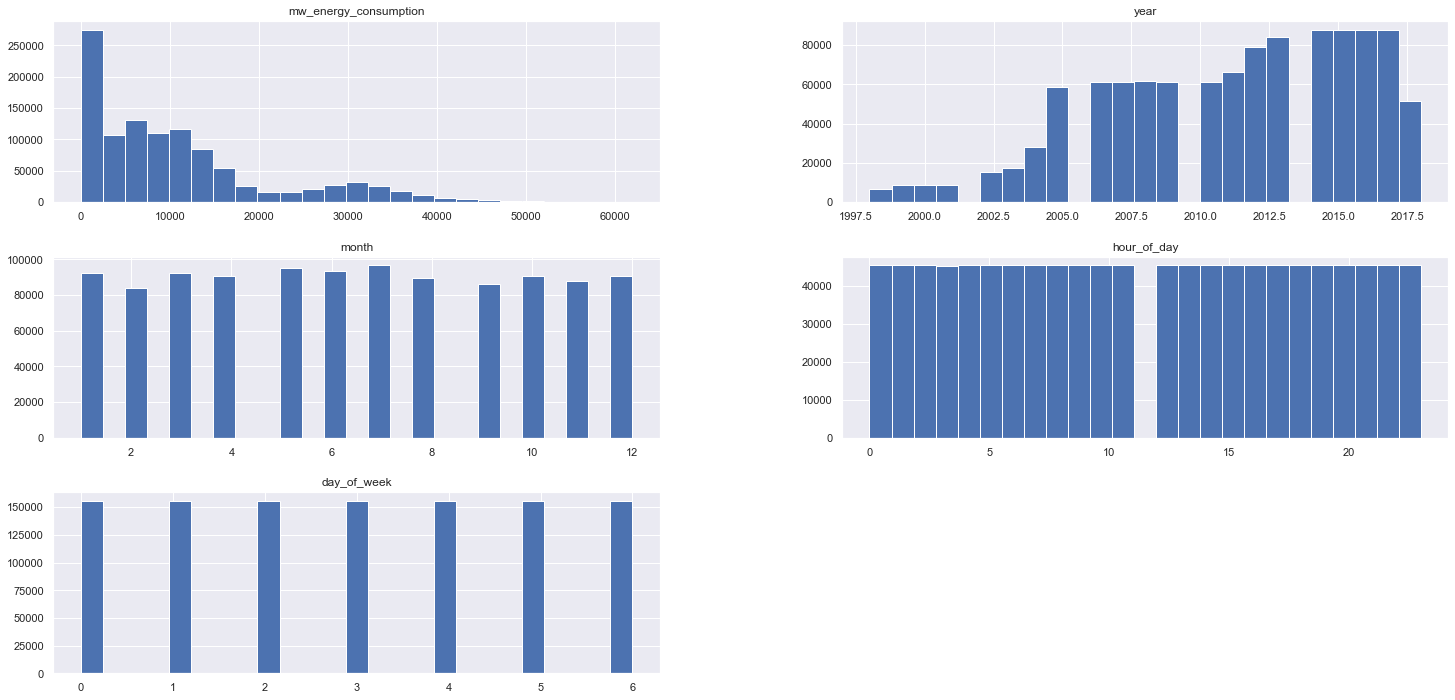

In [45]:
num_attributes.hist( bins=25 )

## Categorical Values

In [46]:
cat_attributes.head()

,electric_company,season,holiday
0,AEP,Winter,True
1,AEP,Winter,True
2,AEP,Winter,True
3,AEP,Winter,True
4,AEP,Winter,True


In [47]:
df4['electric_company'].drop_duplicates()

0       AEP
0     COMED
0    DAYTON
0      DEOK
0       DOM
0       DUQ
0      EKPC
0        FE
0        NI
0       PJM
0      PJME
0      PJMW
Name: electric_company, dtype: object

In [48]:
df4['season'].drop_duplicates()

0       Winter
744     Autumn
5134    Summer
7342    Spring
Name: season, dtype: object

In [49]:
df4['holiday'].drop_duplicates()

0      True
23    False
Name: holiday, dtype: bool

## Plots

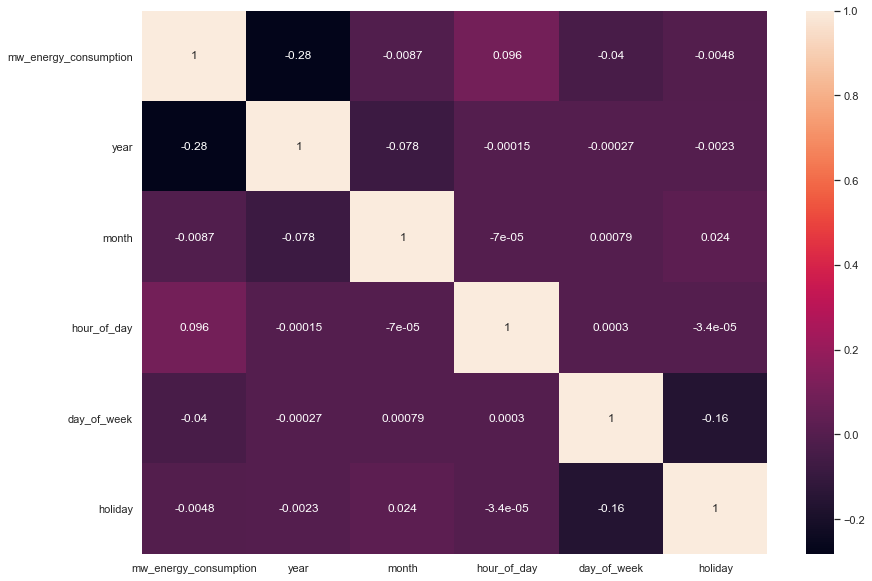

In [50]:
#let's see the correlation by referring the heatmap
plt.figure(figsize=(14,10))
sb.heatmap(df4.corr(), annot=True)
plt.show()

# Woaah... Notice the change from our previous heatmap (df1) which was only one color because of one attribute
# Here we extracted various attributes as we saw above and now we can see them in action showing their correlation with each other

PJME      145366
PJMW      143206
DAYTON    121275
AEP       121273
DUQ       119068
DOM       116189
COMED      66497
FE         62874
NI         58450
DEOK       57739
EKPC       45334
PJM        32896
Name: electric_company, dtype: int64

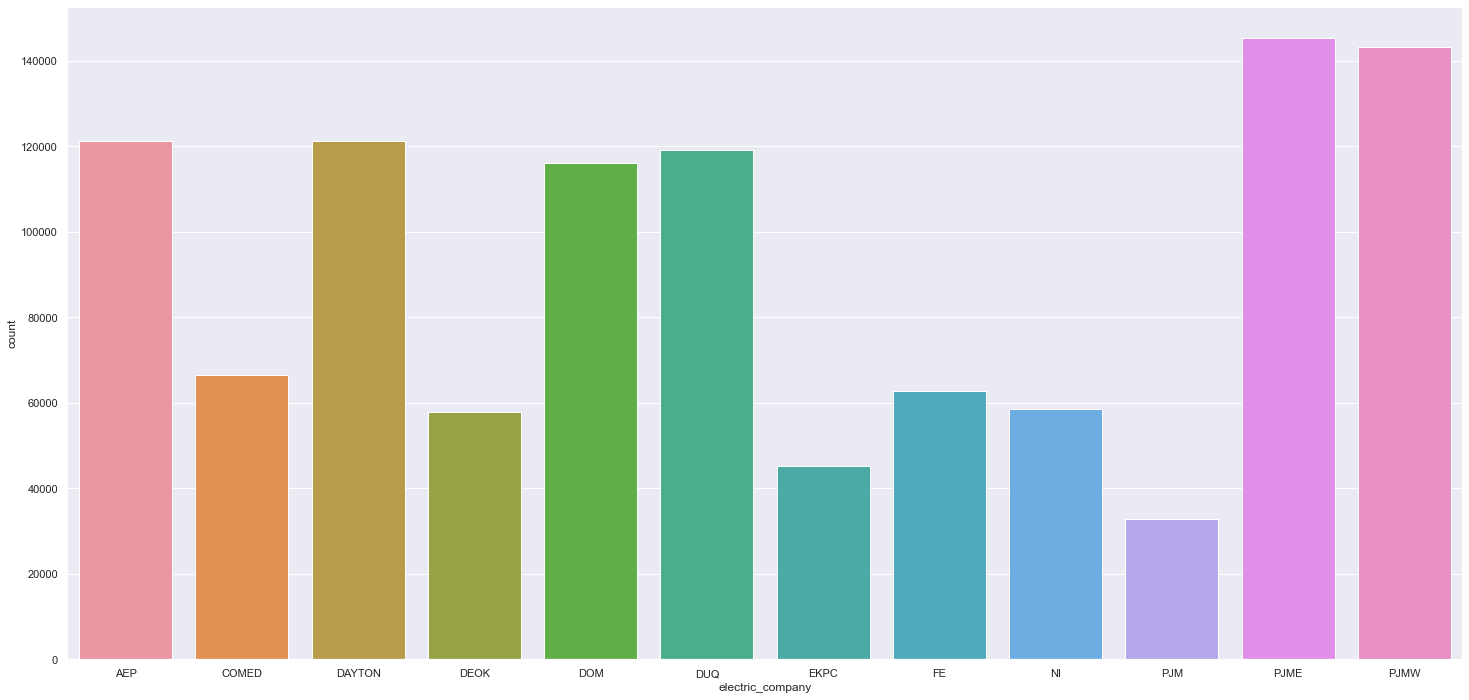

In [51]:
#Let's check the number of classes
sb.countplot(x="electric_company", data=df4)
df.loc[:,'electric_company'].value_counts()

KeyError: 'season'

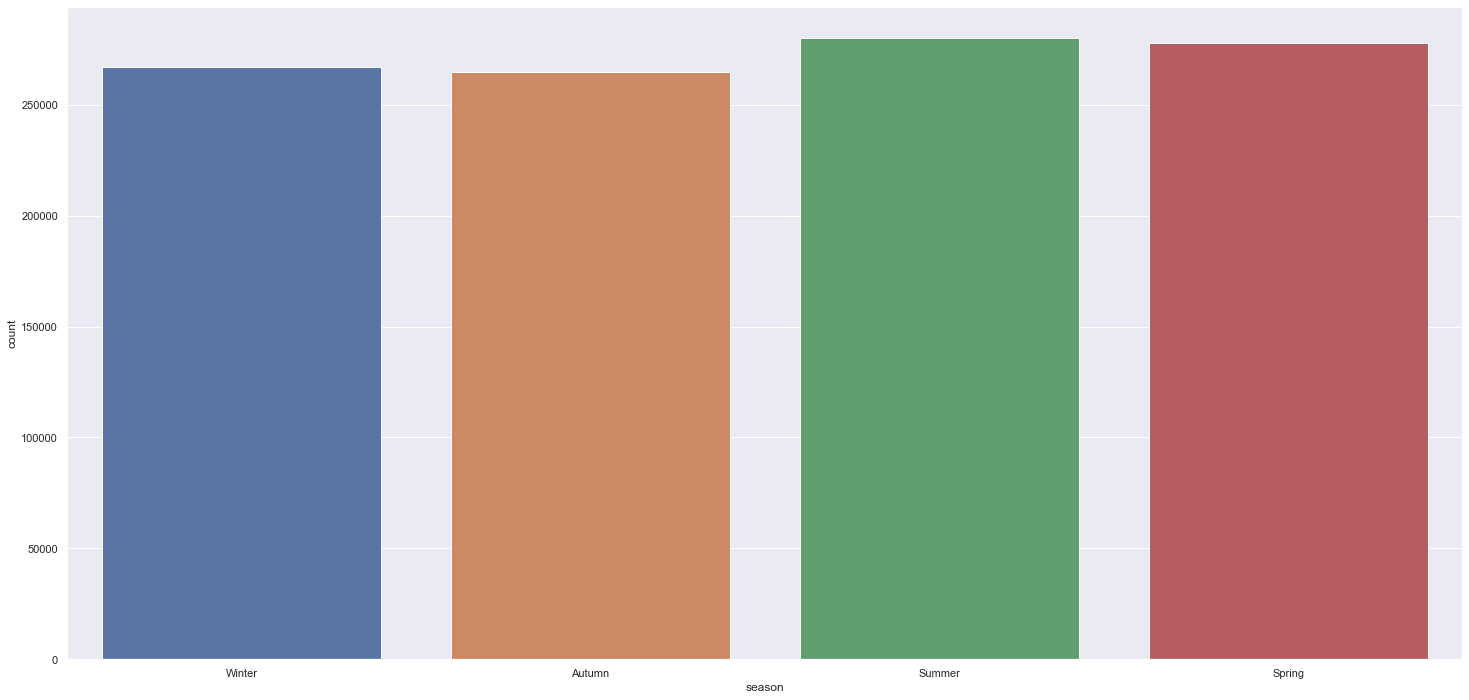

In [52]:
#Let's check the number of classes for different attributes that we had....just to have pictorial representation
# scroll to see the output

sb.countplot(x="season", data=df4)
df.loc[:,'season'].value_counts()

KeyError: 'month'

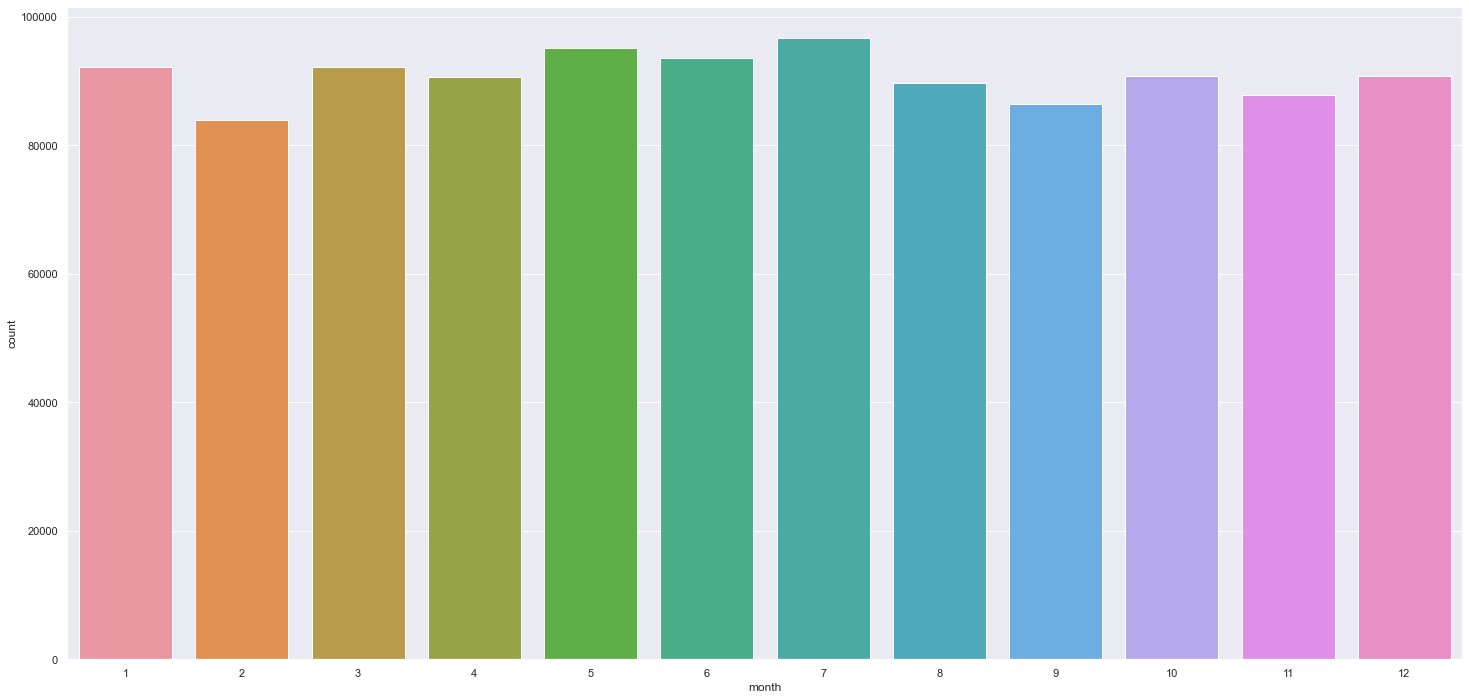

In [54]:
#Let's check the number of classes for different attributes that we had....just to have pictorial representation

sb.countplot(x="month", data=df4)
df.loc[:,'month'].value_counts()

KeyError: 'day_of_week'

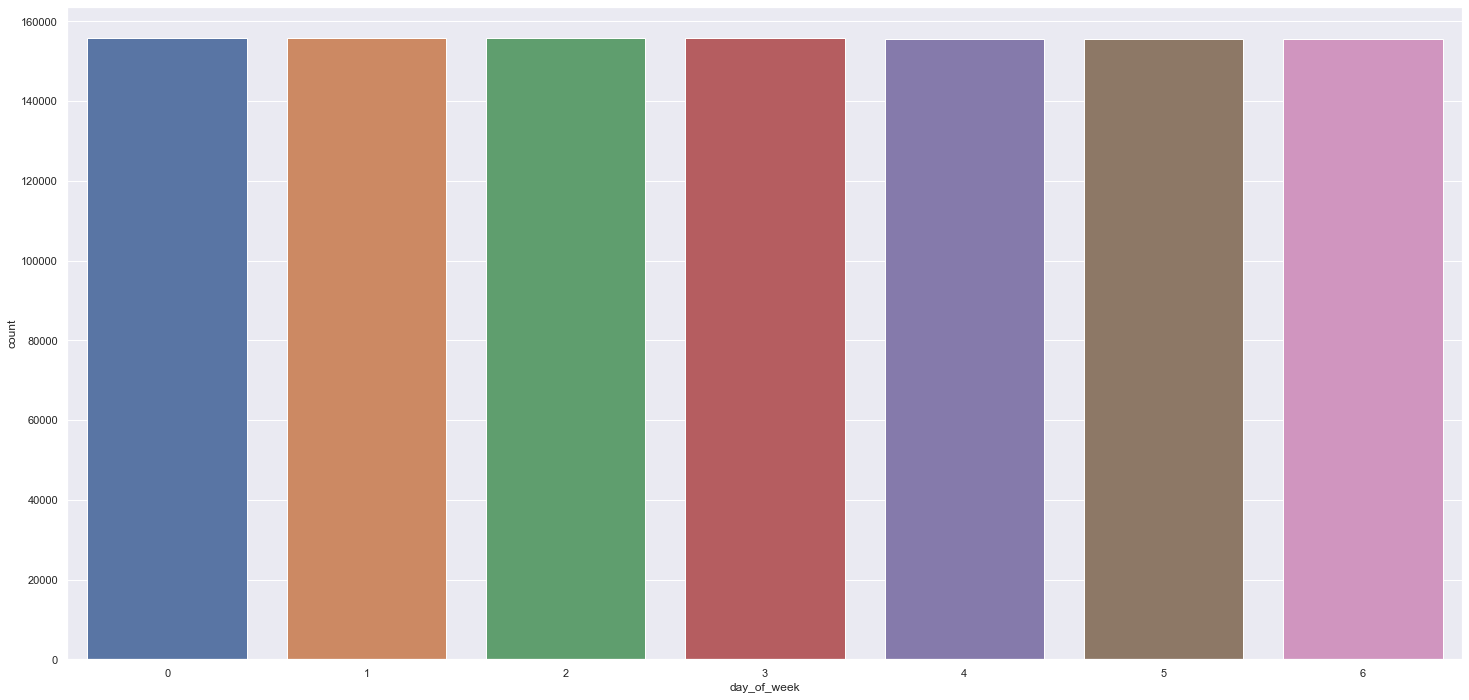

In [55]:
#Let's check the number of classes for different attributes that we had....just to have pictorial representation

sb.countplot(x="day_of_week", data=df4)
df.loc[:,'day_of_week'].value_counts()

KeyError: 'holiday'

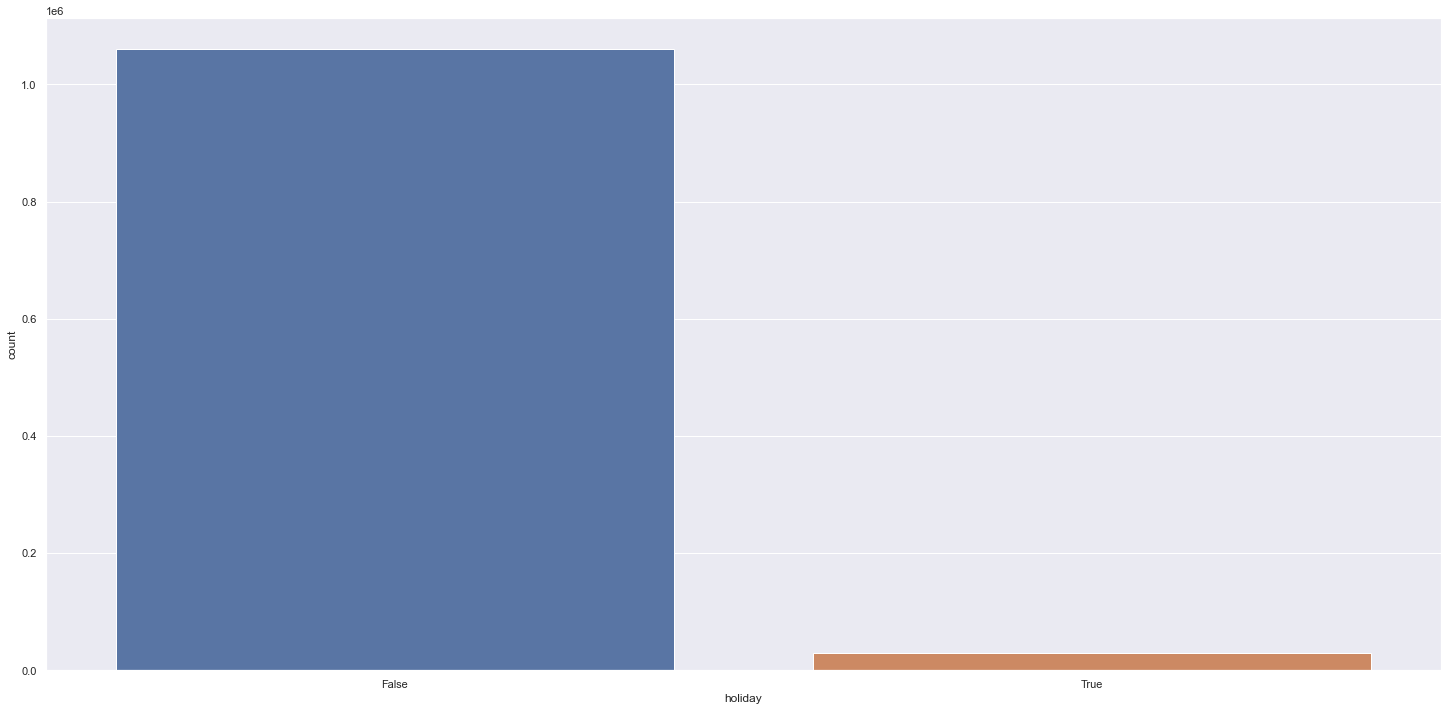

In [56]:
#Let's check the number of classes for different attributes that we had....just to have pictorial representation

sb.countplot(x="holiday", data=df4)
df.loc[:,'holiday'].value_counts()

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


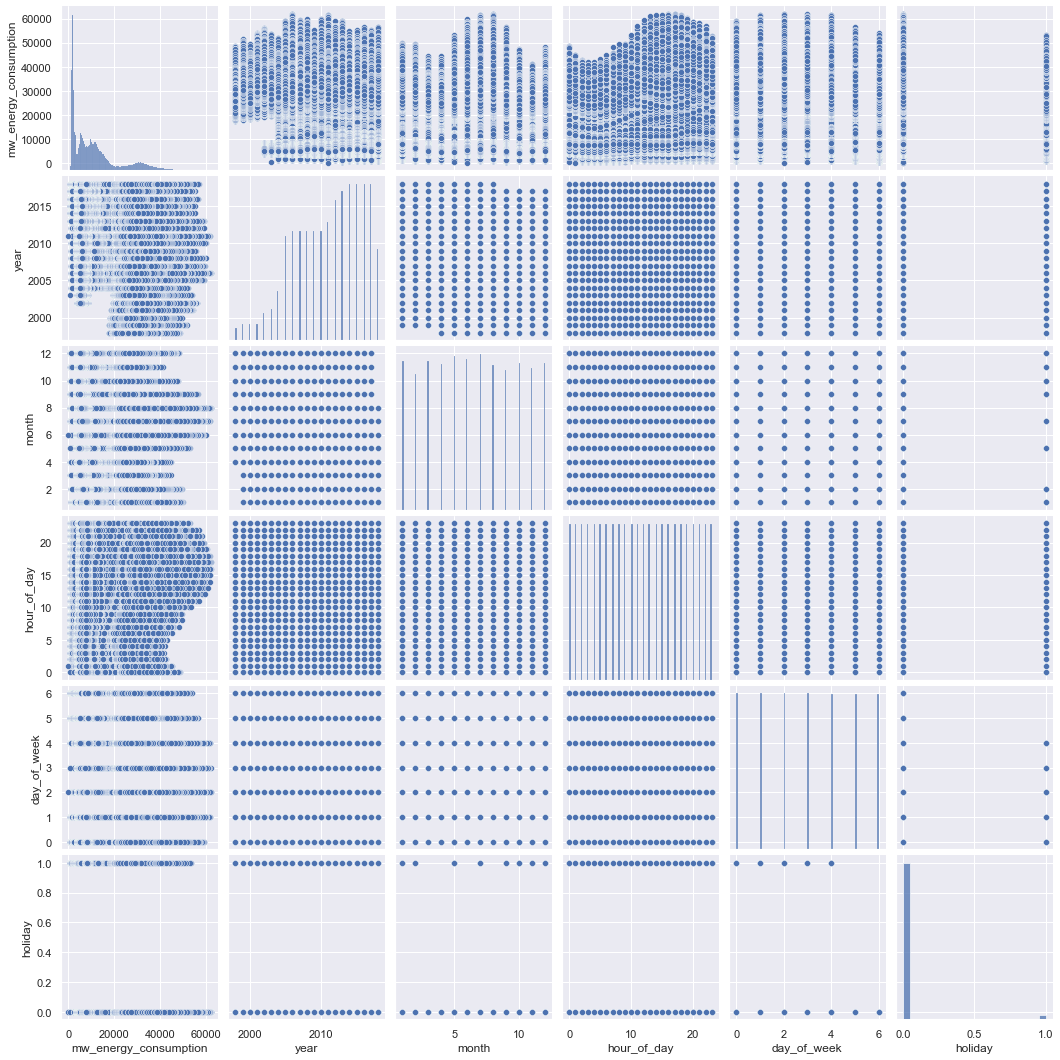

In [57]:
# pairplot
sb.pairplot(df4)
# Similarly as we saw the changes in the heatmap previously, Here also we can see the drastic changes in our pairplot than previous
# Previously we had one pairplot and now see how many we have....all the added attributes against each other showing how they work with each other

# 3.3 Graphical Visualisations


## 1. Hypothesis Analysis - Graph


### H1. Family activity influences energy expenditure in the early morning and late afternoon

**FALSE** Energy consumption increases early in the morning, but it keeps increasing until it has another strong rise in the late afternoon and then falls.

<AxesSubplot:xlabel='hour_of_day', ylabel='mw_energy_consumption'>

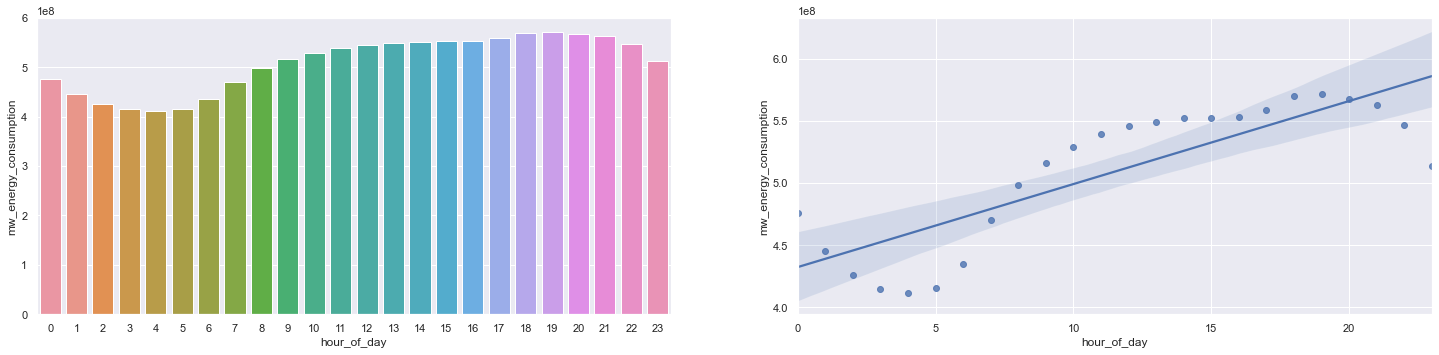

In [58]:
plt.subplot(2,2,1)
aux1 = df4[['hour_of_day', 'mw_energy_consumption']].groupby( 'hour_of_day' ).sum().reset_index()
sb.barplot( x='hour_of_day', y='mw_energy_consumption', data=aux1)

plt.subplot(2,2,2)
sb.regplot( x='hour_of_day', y='mw_energy_consumption', data=aux1 )

### H2. Seasons with higher or lower temperatures use more energy

**TRUE** We see that winter and summer, which are the seasons with the most acute temperatures, register the highest energy consumption.

ValueError: Value for `orient` not understood: ['Winter', 'Spring', 'Summer', 'Autumn']

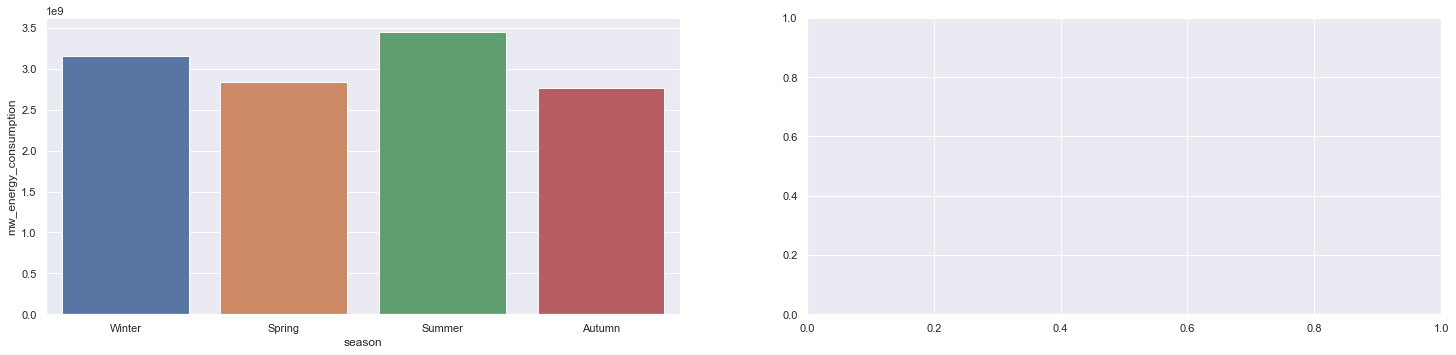

In [60]:
aux1 = df4[['season', 'mw_energy_consumption']].groupby( 'season' ).sum().reset_index()
plt.subplot( 2, 2, 1 )
sb.barplot( x='season', y='mw_energy_consumption', data=aux1, order=['Winter', 'Spring', 'Summer', 'Autumn'] )

aux2 = df4[['year', 'season', 'mw_energy_consumption']].groupby( ['year', 'season'] ).sum().reset_index()
plt.subplot( 2, 2, 2 )
sb.barplot( x='year', y='mw_energy_consumption', hue='season', data=aux2, orient=['Winter', 'Spring', 'Summer', 'Autumn'] );

### H3. Holiday periods spend more energy

**FALSE** Holiday periods spend less energy

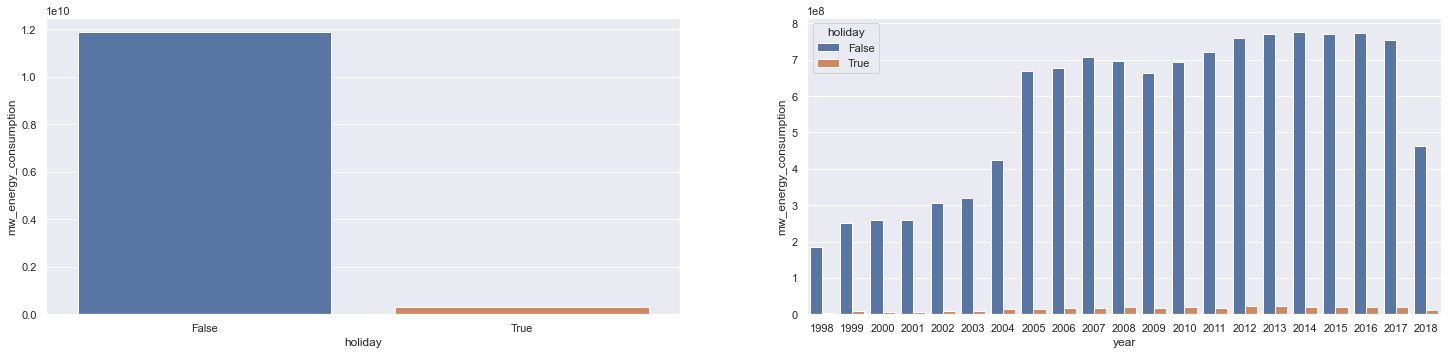

In [61]:
aux1 = df3[['holiday', 'mw_energy_consumption']].groupby( 'holiday' ).sum().reset_index()
plt.subplot( 2, 2, 1 )
sb.barplot( x='holiday', y='mw_energy_consumption', data=aux1 )

aux2 = df3[['year', 'holiday', 'mw_energy_consumption']].groupby( ['year', 'holiday'] ).sum().reset_index()
plt.subplot( 2, 2, 2 )
sb.barplot( x='year', y='mw_energy_consumption', hue='holiday', data=aux2 );

### H4. Weekends periods spend more energy

**FALSE** Weekends periods spend less energy

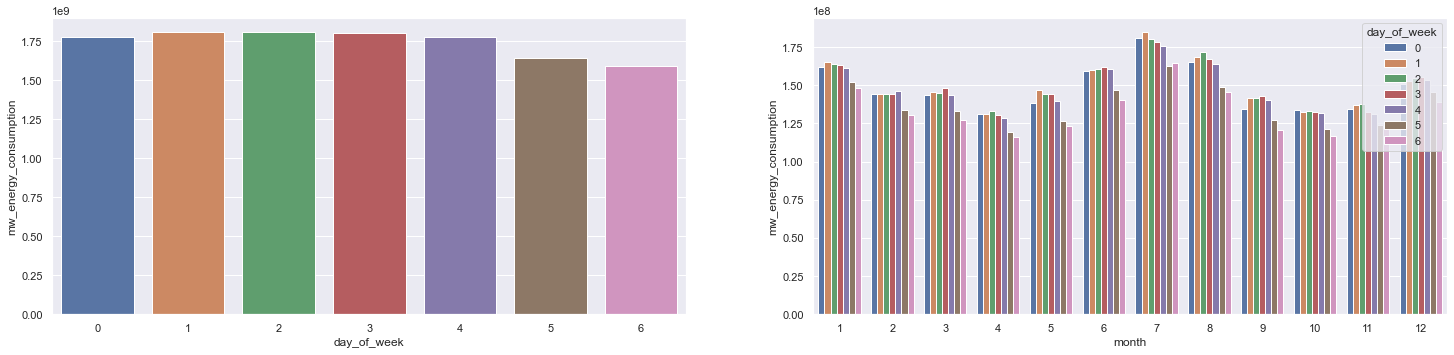

In [62]:
plt.subplot( 2, 2, 1)
aux1 = df4[['day_of_week', 'mw_energy_consumption']].groupby( 'day_of_week' ).sum().reset_index()
sb.barplot( x='day_of_week', y='mw_energy_consumption', data=aux1)

aux2 = df4[['month', 'day_of_week', 'mw_energy_consumption']].groupby( ['month', 'day_of_week'] ).sum().reset_index()
plt.subplot( 2, 2, 2 )
sb.barplot( x='month', y='mw_energy_consumption', hue='day_of_week', data=aux2 );

# To better understand what these numbers represent in relation to the days of the week follow the legend below:
# Integer Value             Day of the week
#      0                        Monday
#      1                       Tuesday
#      2                      Wednesday
#      3                      Thursday
#      4                       Friday
#      5                      Saturday
#      6                       Sunday

# 4. Further processing of data

In [27]:
df5 = df4.copy()

#df5 = pd.get_dummies( df5, prefix=['holidays'], columns=['holidays'] )

df5['hour_of_day_sin'] = df5['hour_of_day'].apply(lambda x: np.sin( x * ( 2. * np.pi/24 ) ))

df5['hour_of_day_cos'] = df5['hour_of_day'].apply(lambda x: np.cos( x * ( 2. * np.pi/24 ) ))

encode_season = {'Winter':1,'Spring':2, 'Summer':3, 'Autumn':4}
df5['season'] = df5['season'].map(encode_season)

df5['season_sin'] = df5['season'].apply(lambda x: np.sin( x * ( 2. * np.pi/4 ) ))

df5['season_cos'] = df5['season'].apply(lambda x: np.cos( x * ( 2. * np.pi/4 ) ))

df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7)))

df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))

In [28]:
df5.columns.nunique()

16

In [29]:
df5['mw_energy_consumption'] = np.log1p( df5['mw_energy_consumption'] )

In [30]:
df5.head()

,datetime,mw_energy_consumption,electric_company,date,year,month,hour_of_day,season,day_of_week,holiday,hour_of_day_sin,hour_of_day_cos,season_sin,season_cos,day_of_week_sin,day_of_week_cos
0,2004-12-31 01:00:00,9.508888,AEP,2004-12-31,2004,12,1,1,4,True,0.258819,0.965926,1.0,6.123234e-17,-0.433884,-0.900969
1,2004-12-31 02:00:00,9.462343,AEP,2004-12-31,2004,12,2,1,4,True,0.500000,0.866025,1.0,6.123234e-17,-0.433884,-0.900969
2,2004-12-31 03:00:00,9.439705,AEP,2004-12-31,2004,12,3,1,4,True,0.707107,0.707107,1.0,6.123234e-17,-0.433884,-0.900969
3,2004-12-31 04:00:00,9.434923,AEP,2004-12-31,2004,12,4,1,4,True,0.866025,0.500000,1.0,6.123234e-17,-0.433884,-0.900969
4,2004-12-31 05:00:00,9.447071,AEP,2004-12-31,2004,12,5,1,4,True,0.965926,0.258819,1.0,6.123234e-17,-0.433884,-0.900969


In [31]:
df5.columns

Index(['datetime', 'mw_energy_consumption', 'electric_company', 'date', 'year',
       'month', 'hour_of_day', 'season', 'day_of_week', 'holiday',
       'hour_of_day_sin', 'hour_of_day_cos', 'season_sin', 'season_cos',
       'day_of_week_sin', 'day_of_week_cos'],
      dtype='object')

In [32]:
df6 = df5.copy()

df6 = df6.drop(['year','month', 'hour_of_day','season','day_of_week'],axis = 1)
df6.head()

,datetime,mw_energy_consumption,electric_company,date,holiday,hour_of_day_sin,hour_of_day_cos,season_sin,season_cos,day_of_week_sin,day_of_week_cos
0,2004-12-31 01:00:00,9.508888,AEP,2004-12-31,True,0.258819,0.965926,1.0,6.123234e-17,-0.433884,-0.900969
1,2004-12-31 02:00:00,9.462343,AEP,2004-12-31,True,0.500000,0.866025,1.0,6.123234e-17,-0.433884,-0.900969
2,2004-12-31 03:00:00,9.439705,AEP,2004-12-31,True,0.707107,0.707107,1.0,6.123234e-17,-0.433884,-0.900969
3,2004-12-31 04:00:00,9.434923,AEP,2004-12-31,True,0.866025,0.500000,1.0,6.123234e-17,-0.433884,-0.900969
4,2004-12-31 05:00:00,9.447071,AEP,2004-12-31,True,0.965926,0.258819,1.0,6.123234e-17,-0.433884,-0.900969


## Splitting the dataframe

In [33]:
min_max_date = []
    
company = [i for i in df6['electric_company'].unique()]
print(company)

for i in company:
    min_max_date.append( [ i, df6[df6['electric_company']==i]['date'].min(), df6[df6['electric_company']==i]['date'].max() ] )
    
time_data = pd.DataFrame(columns = ['electric_company','min_date','max_date'], data = min_max_date)

time_data['difference'] = time_data['max_date'] - time_data['min_date']
time_data

['AEP', 'COMED', 'DAYTON', 'DEOK', 'DOM', 'DUQ', 'EKPC', 'FE', 'NI', 'PJM', 'PJME', 'PJMW']


,electric_company,min_date,max_date,difference
0,AEP,2004-10-01,2018-08-03,5054 days
1,COMED,2011-01-01,2018-08-03,2771 days
2,DAYTON,2004-10-01,2018-08-03,5054 days
3,DEOK,2012-01-01,2018-08-03,2406 days
4,DOM,2005-05-01,2018-08-03,4842 days
5,DUQ,2005-01-01,2018-08-03,4962 days
6,EKPC,2013-06-01,2018-08-03,1889 days
7,FE,2011-06-01,2018-08-03,2620 days
8,NI,2004-05-01,2011-01-01,2436 days
9,PJM,1998-04-01,2002-01-01,1371 days


In [34]:
# CUTOFF DATE = max_date - 12 months

# SO TRAINING DATA HAS DATE => min_date < TRAINING DATE < CUTOFF DATE
# TESTING DATA HAS DATE => CUTOFF DATE < TESTING DATE < max_date

# TESTING DATA HAS DATA FOR ONE YEAR OF EACH COMPANY

cutoff = []

for i in range( 0, 12 ):
    cutoff.append([time_data['max_date'][i] - datetime.timedelta(days = 365)])

In [35]:
time_data['cutoff'] = pd.DataFrame(columns = ['cutoff'], data = cutoff)

time_data

,electric_company,min_date,max_date,difference,cutoff
0,AEP,2004-10-01,2018-08-03,5054 days,2017-08-03
1,COMED,2011-01-01,2018-08-03,2771 days,2017-08-03
2,DAYTON,2004-10-01,2018-08-03,5054 days,2017-08-03
3,DEOK,2012-01-01,2018-08-03,2406 days,2017-08-03
4,DOM,2005-05-01,2018-08-03,4842 days,2017-08-03
5,DUQ,2005-01-01,2018-08-03,4962 days,2017-08-03
6,EKPC,2013-06-01,2018-08-03,1889 days,2017-08-03
7,FE,2011-06-01,2018-08-03,2620 days,2017-08-03
8,NI,2004-05-01,2011-01-01,2436 days,2010-01-01
9,PJM,1998-04-01,2002-01-01,1371 days,2001-01-01


In [36]:
x_train = df6[ ( ( (df6['electric_company']=='AEP') 
                 | (df6['electric_company']=='COMED') 
                 | (df6['electric_company']=='DAYTON') 
                 | (df6['electric_company']=='DEOK') 
                 | (df6['electric_company']=='DOM') 
                 | (df6['electric_company']=='DUQ') 
                 | (df6['electric_company']=='EKPC') 
                 | (df6['electric_company']=='FE') 
                 | (df6['electric_company']=='PJME') 
                 | (df6['electric_company']=='PJMW') ) & (df6['date'] < '2017-08-03') ) 
                 | (df6['electric_company']=='NI') & (df6['date'] < '2010-01-01') 
                 | (df6['electric_company']=='PJM') & (df6['date'] < '2001-01-01') ]

y_train = x_train['mw_energy_consumption']

x_test = df6[ ( ( (df6['electric_company']=='AEP') 
                 | (df6['electric_company']=='COMED') 
                 | (df6['electric_company']=='DAYTON') 
                 | (df6['electric_company']=='DEOK') 
                 | (df6['electric_company']=='DOM') 
                 | (df6['electric_company']=='DUQ') 
                 | (df6['electric_company']=='EKPC') 
                 | (df6['electric_company']=='FE') 
                 | (df6['electric_company']=='PJME') 
                 | (df6['electric_company']=='PJMW') ) & (df6['date'] >= '2017-08-03') ) 
                 | (df6['electric_company']=='NI') & (df6['date'] >= '2010-01-01') 
                 | (df6['electric_company']=='PJM') & (df6['date'] >= '2001-01-01') ]

y_test = x_test['mw_energy_consumption']

train_test = []

for i in df6['electric_company'].unique():
    train_test.append([i, x_train[x_train['electric_company'] == i]['date'].min(), 
                       x_train[x_train['electric_company'] == i]['date'].max(),
                       x_test[x_test['electric_company'] == i]['date'].min(), 
                       x_test[x_test['electric_company'] == i]['date'].max()])
    
tt = pd.DataFrame(columns = ['electric_company','train_min','train_max','test_min','test_max'],data = train_test)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
  
x_train['electric_company']= le.fit_transform(x_train['electric_company'])
x_test['electric_company']= le.fit_transform(x_test['electric_company'])

<ipython-input-36-e0202238465b>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['electric_company']= le.fit_transform(x_train['electric_company'])
<ipython-input-36-e0202238465b>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['electric_company']= le.fit_transform(x_test['electric_company'])


In [37]:
x_train.head()

,datetime,mw_energy_consumption,electric_company,date,holiday,hour_of_day_sin,hour_of_day_cos,season_sin,season_cos,day_of_week_sin,day_of_week_cos
0,2004-12-31 01:00:00,9.508888,0,2004-12-31,True,0.258819,0.965926,1.0,6.123234e-17,-0.433884,-0.900969
1,2004-12-31 02:00:00,9.462343,0,2004-12-31,True,0.500000,0.866025,1.0,6.123234e-17,-0.433884,-0.900969
2,2004-12-31 03:00:00,9.439705,0,2004-12-31,True,0.707107,0.707107,1.0,6.123234e-17,-0.433884,-0.900969
3,2004-12-31 04:00:00,9.434923,0,2004-12-31,True,0.866025,0.500000,1.0,6.123234e-17,-0.433884,-0.900969
4,2004-12-31 05:00:00,9.447071,0,2004-12-31,True,0.965926,0.258819,1.0,6.123234e-17,-0.433884,-0.900969


In [38]:
tt

,electric_company,train_min,train_max,test_min,test_max
0,AEP,2004-10-01,2017-08-07,2017-08-08,2018-08-03
1,COMED,2011-01-01,2017-08-07,2017-08-08,2018-08-03
2,DAYTON,2004-10-01,2017-08-07,2017-08-08,2018-08-03
3,DEOK,2012-01-01,2017-08-07,2017-08-08,2018-08-03
4,DOM,2005-05-01,2017-08-07,2017-08-08,2018-08-03
5,DUQ,2005-01-01,2017-08-07,2017-08-08,2018-08-03
6,EKPC,2013-06-01,2017-08-07,2017-08-08,2018-08-03
7,FE,2011-06-01,2017-08-07,2017-08-08,2018-08-03
8,NI,2004-05-01,2010-01-05,2010-01-06,2011-01-01
9,PJM,1998-04-01,2001-01-05,2001-01-06,2002-01-01


In [39]:
x_train_b = x_train.drop(['date','datetime','mw_energy_consumption'],axis = 1)
features = x_train_b.columns

x_train_b = x_train_b.values
y_train_b = y_train.values.ravel()

y_train_b

array([9.5088882 , 9.46234345, 9.43970454, ..., 8.62047154, 8.57772369,
       8.52158354])

# Boruta as feature selector

In [40]:
rf = RandomForestRegressor( n_jobs = -1 )

# define Boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state = 42 ).fit( x_train_b, y_train_b )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	5
Tentative: 	0
Rejected: 	3


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	5
Tentative: 	0
Rejected: 	3


In [41]:
##Best feature selection

feature_ranks = list(zip(features, boruta.ranking_, boruta.support_))
cols_selected = boruta.support_.tolist()


for feat in feature_ranks:
    print('Feature : {:<30} Rank: {}, Keep: {}'.format(feat[0], feat[1], feat[2]))

Feature : electric_company               Rank: 1, Keep: True
Feature : holiday                        Rank: 4, Keep: False
Feature : hour_of_day_sin                Rank: 1, Keep: True
Feature : hour_of_day_cos                Rank: 1, Keep: True
Feature : season_sin                     Rank: 1, Keep: True
Feature : season_cos                     Rank: 2, Keep: False
Feature : day_of_week_sin                Rank: 1, Keep: True
Feature : day_of_week_cos                Rank: 3, Keep: False


In [42]:
# best feature
x_train_fs = x_train.drop( ['date', 'datetime', 'mw_energy_consumption'], axis=1 )
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.tolist()

# not selected boruta
cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))

In [43]:
cols_selected_boruta

['electric_company',
 'hour_of_day_sin',
 'hour_of_day_cos',
 'season_sin',
 'day_of_week_sin']

In [44]:
cols_selected_boruta = [
     'electric_company',
     'hour_of_day_sin',
     'hour_of_day_cos',
     'season_sin',
     'season_cos',
     'day_of_week_sin',
     'day_of_week_cos']

feat_to_add = ['datetime', 'mw_energy_consumption']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

cols_selected_boruta_full

['electric_company',
 'hour_of_day_sin',
 'hour_of_day_cos',
 'season_sin',
 'season_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'datetime',
 'mw_energy_consumption']

In [45]:
cols_selected_boruta

['electric_company',
 'hour_of_day_sin',
 'hour_of_day_cos',
 'season_sin',
 'season_cos',
 'day_of_week_sin',
 'day_of_week_cos']

In [46]:
x_train.columns

Index(['datetime', 'mw_energy_consumption', 'electric_company', 'date',
       'holiday', 'hour_of_day_sin', 'hour_of_day_cos', 'season_sin',
       'season_cos', 'day_of_week_sin', 'day_of_week_cos'],
      dtype='object')

In [47]:
x_train

,datetime,mw_energy_consumption,electric_company,date,holiday,hour_of_day_sin,hour_of_day_cos,season_sin,season_cos,day_of_week_sin,day_of_week_cos
0,2004-12-31 01:00:00,9.508888,0,2004-12-31,True,0.258819,0.965926,1.0,6.123234e-17,-0.433884,-0.900969
1,2004-12-31 02:00:00,9.462343,0,2004-12-31,True,0.500000,0.866025,1.0,6.123234e-17,-0.433884,-0.900969
2,2004-12-31 03:00:00,9.439705,0,2004-12-31,True,0.707107,0.707107,1.0,6.123234e-17,-0.433884,-0.900969
3,2004-12-31 04:00:00,9.434923,0,2004-12-31,True,0.866025,0.500000,1.0,6.123234e-17,-0.433884,-0.900969
4,2004-12-31 05:00:00,9.447071,0,2004-12-31,True,0.965926,0.258819,1.0,6.123234e-17,-0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...
138066,2017-01-01 20:00:00,8.646641,11,2017-01-01,False,-0.866025,0.500000,1.0,6.123234e-17,-0.781831,0.623490
138067,2017-01-01 21:00:00,8.642768,11,2017-01-01,False,-0.707107,0.707107,1.0,6.123234e-17,-0.781831,0.623490
138068,2017-01-01 22:00:00,8.620472,11,2017-01-01,False,-0.500000,0.866025,1.0,6.123234e-17,-0.781831,0.623490
138069,2017-01-01 23:00:00,8.577724,11,2017-01-01,False,-0.258819,0.965926,1.0,6.123234e-17,-0.781831,0.623490


# 5. Machine Learning Modelling

In [48]:
x_main_train = x_train[cols_selected_boruta]
x_main_test = x_test[cols_selected_boruta]
y_main_train = y_train
y_main_test = y_test

# Time Series Data Preparartion
x_training = x_train[cols_selected_boruta_full]

x_main_train.head()

,electric_company,hour_of_day_sin,hour_of_day_cos,season_sin,season_cos,day_of_week_sin,day_of_week_cos
0,0,0.258819,0.965926,1.0,6.123234e-17,-0.433884,-0.900969
1,0,0.500000,0.866025,1.0,6.123234e-17,-0.433884,-0.900969
2,0,0.707107,0.707107,1.0,6.123234e-17,-0.433884,-0.900969
3,0,0.866025,0.500000,1.0,6.123234e-17,-0.433884,-0.900969
4,0,0.965926,0.258819,1.0,6.123234e-17,-0.433884,-0.900969


In [49]:
def mean_absolute_percentage_error( y_test, y_predict ):
    return np.mean( np.abs( (y_test - y_predict ) / y_test ) )

def ml_error( model_name, y_test , y_predict ):
    mae = mean_absolute_error( y_test, y_predict )
    mape = mean_absolute_percentage_error( y_test, y_predict )
    rmse = np.sqrt( mean_squared_error( y_test, y_predict ) )
    
    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE': mae,
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

### LINEAR REGRESSION MODEL

In [50]:
lr = LinearRegression()
lr.fit(x_main_train,y_train)
y_predict_lr = lr.predict(x_main_test)

y_predict_lr

array([8.33739716, 8.31390823, 8.29850876, ..., 9.18463003, 9.14810668,
       9.16494351])

In [52]:
lr_result = ml_error('Linear Regression', np.expm1(y_main_test), np.expm1(y_predict_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,7533.677496,1.196289,10380.863359


### RANDOM FOREST REGRESSOR

In [87]:
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 )
rf.fit( x_main_train, y_main_train )
y_predict_rf = rf.predict(x_main_test)

In [54]:
rf_result = ml_error('Random Forest Regressor', np.expm1(y_main_test), np.expm1(y_predict_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,996.069415,0.092969,1754.901608


In [59]:
df9 = x_test[ cols_selected_boruta_full ]

df9['mw_energy_consumption'] = np.expm1( df9['mw_energy_consumption'] )
df9['predictions'] = np.expm1( y_predict_rf )
df9.head()

<ipython-input-59-fcc3340881bd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['mw_energy_consumption'] = np.expm1( df9['mw_energy_consumption'] )
<ipython-input-59-fcc3340881bd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1( y_predict_rf )


,electric_company,hour_of_day_sin,hour_of_day_cos,season_sin,season_cos,day_of_week_sin,day_of_week_cos,datetime,mw_energy_consumption,predictions
107378,0,0.258819,0.965926,1.0,6.123234e-17,-0.781831,0.62349,2017-12-31 01:00:00,17422.0,14820.292850
107379,0,0.500000,0.866025,1.0,6.123234e-17,-0.781831,0.62349,2017-12-31 02:00:00,17219.0,14493.130696
107380,0,0.707107,0.707107,1.0,6.123234e-17,-0.781831,0.62349,2017-12-31 03:00:00,17313.0,14368.232247
107381,0,0.866025,0.500000,1.0,6.123234e-17,-0.781831,0.62349,2017-12-31 04:00:00,17396.0,14352.818618
107382,0,0.965926,0.258819,1.0,6.123234e-17,-0.781831,0.62349,2017-12-31 05:00:00,17512.0,14434.681326


In [60]:
# Now we are going to take the mathematical numbers, represented by the predictions and their errors, and translate it into a business result.
# In the case of this project, let's say what the error tells us regarding the amount of energy consumed in the next year in each electric company.

# sum of predictions
df91 = df9[['electric_company', 'predictions']].groupby( 'electric_company' ).sum().reset_index()

# MAE e MAPE
df9_aux1 = df9[['electric_company', 'mw_energy_consumption', 'predictions']].groupby( 'electric_company' ).apply( lambda x: mean_absolute_error( x['mw_energy_consumption'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'} )
df9_aux2 = df9[['electric_company', 'mw_energy_consumption', 'predictions']].groupby( 'electric_company' ).apply( lambda x: mean_absolute_percentage_error( x['mw_energy_consumption'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'} )

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='electric_company' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='electric_company' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAPE']

# order columns
df92 = df92[['electric_company', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [61]:
df9_aux1.head(12)

,electric_company,MAE
0,0,1373.995362
1,1,982.033211
2,2,177.136383
3,3,305.492909
4,4,1364.318867
5,5,157.229156
6,6,222.033245
7,7,568.267712
8,8,941.510076
9,9,2186.587130


In [62]:
df92.head(12)

,electric_company,predictions,worst_scenario,best_scenario,MAE,MAPE
0,0,1.335021e+08,1.335007e+08,1.335021e+08,1373.995362,0.093243
1,1,9.801517e+07,9.801419e+07,9.801517e+07,982.033211,0.083513
2,2,1.749397e+07,1.749379e+07,1.749397e+07,177.136383,0.086452
3,3,2.655776e+07,2.655746e+07,2.655776e+07,305.492909,0.097933
4,4,9.321629e+07,9.321492e+07,9.321629e+07,1364.318867,0.111970
5,5,1.429278e+07,1.429262e+07,1.429278e+07,157.229156,0.101133
6,6,1.233415e+07,1.233393e+07,1.233415e+07,222.033245,0.136654
7,7,6.688540e+07,6.688483e+07,6.688540e+07,568.267712,0.071716
8,8,1.001542e+08,1.001532e+08,1.001542e+08,941.510076,0.074040
9,9,2.540310e+08,2.540289e+08,2.540310e+08,2186.587130,0.069375


<AxesSubplot:xlabel='electric_company', ylabel='MAPE'>

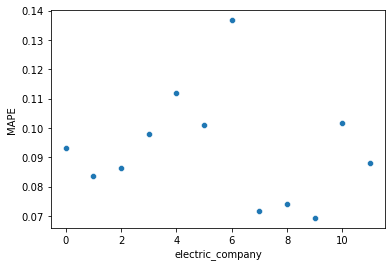

In [64]:
# MEAN ABOSULTE PERCENTAGE ERROR

sb.scatterplot( x='electric_company', y='MAPE', data=df92 )

In [65]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( '{:,.2f} MW'.format )
df93

,Scenario,Values
0,predictions,"1,140,135,338.56 MW"
1,worst_scenario,"1,140,123,385.47 MW"
2,best_scenario,"1,140,135,339.68 MW"


In [74]:
df9['error'] = df9['mw_energy_consumption'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['mw_energy_consumption']

# Remember that, as we have the forecast within three different years, I have separated them into three different datasets for better visualization.
df9_1 = df9[(df9['electric_company']==1) | (df9['electric_company']==2) | (df9['electric_company']==3) | (df9['electric_company']==4) | (df9['electric_company']==5) | (df9['electric_company']==6)
           | (df9['electric_company']==7) | (df9['electric_company']==8) | (df9['electric_company']==11) | (df9['electric_company']==12)]
df9_2 = df9[df9['electric_company']==9]
df9_3 = df9[df9['electric_company']==10]

<AxesSubplot:xlabel='datetime', ylabel='mw_energy_consumption'>

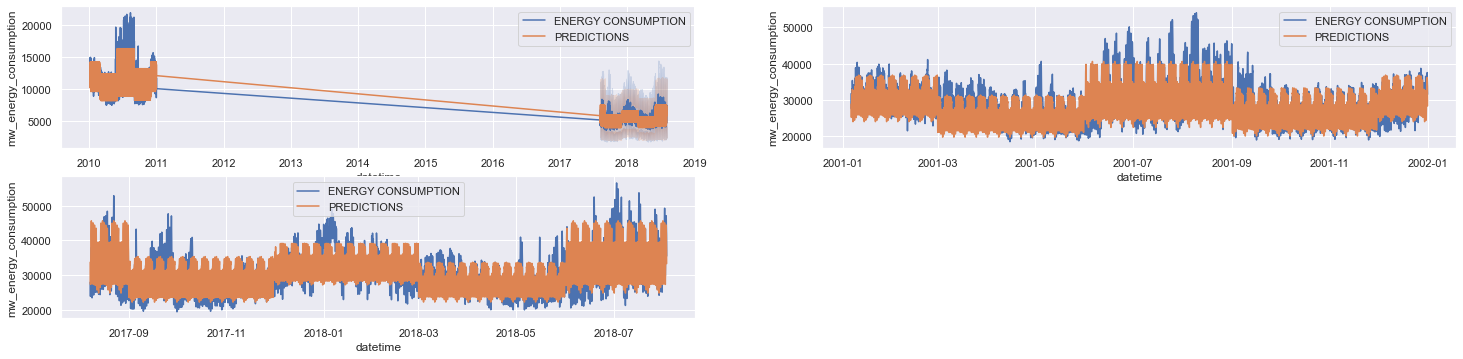

In [75]:
# Compare the real response with the one predicted and observe if the model is performing well. 
plt.subplot( 4, 2, 1 )
sb.lineplot( x='datetime', y='mw_energy_consumption', data=df9_1, label='ENERGY CONSUMPTION' )
sb.lineplot( x='datetime', y='predictions', data=df9_1, label='PREDICTIONS' )

plt.subplot( 4, 2, 2 )
sb.lineplot( x='datetime', y='mw_energy_consumption', data=df9_2, label='ENERGY CONSUMPTION' )
sb.lineplot( x='datetime', y='predictions', data=df9_2, label='PREDICTIONS' )

plt.subplot( 4, 2, 3 )
sb.lineplot( x='datetime', y='mw_energy_consumption', data=df9_3, label='ENERGY CONSUMPTION' )
sb.lineplot( x='datetime', y='predictions', data=df9_3, label='PREDICTIONS' )

In [76]:
x_main_train.head()

,electric_company,hour_of_day_sin,hour_of_day_cos,season_sin,season_cos,day_of_week_sin,day_of_week_cos
0,0,0.258819,0.965926,1.0,6.123234e-17,-0.433884,-0.900969
1,0,0.500000,0.866025,1.0,6.123234e-17,-0.433884,-0.900969
2,0,0.707107,0.707107,1.0,6.123234e-17,-0.433884,-0.900969
3,0,0.866025,0.500000,1.0,6.123234e-17,-0.433884,-0.900969
4,0,0.965926,0.258819,1.0,6.123234e-17,-0.433884,-0.900969
